In [1]:
import scanpy as sc
import cellbin_moran as cm
import squidpy as sq
import anndata as ad
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor, as_completed

# Scanpy Settings
sc.logging.print_versions()
sc.set_figure_params(facecolor="white", figsize=(8, 8))
sc.settings.verbosity = 3

-----
anndata     0.10.7
scanpy      1.10.1
-----
PIL                         9.2.0
anyio                       NA
arrow                       1.3.0
asciitree                   NA
asttokens                   NA
attr                        23.2.0
attrs                       23.2.0
babel                       2.14.0
brotli                      1.1.0
cellbin_moran               NA
certifi                     2024.02.02
cffi                        1.16.0
charset_normalizer          3.3.2
cloudpickle                 3.0.0
colorama                    0.4.6
comm                        0.2.2
cycler                      0.12.1
cython_runtime              NA
dask                        2024.4.2
dask_expr                   1.0.13
dask_image                  2023.08.1
datashader                  0.16.1
datatree                    0.0.14
dateutil                    2.9.0
debugpy                     1.8.1
decorator                   5.1.1
defusedxml                  0.7.1
dill                       

In [6]:
dir(cm)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'analysis',
 'compute_moranI',
 'concatenate_and_intersect',
 'hierarchical_sample',
 'io',
 'list_files_matching_criteria',
 'load_data_in_parallel',
 'load_sct_and_set_index',
 'subset_anndata']

In [2]:
month = "01"

# Reusing the previously defined functions:
cellbin_dir = "/public/home/jijh/st_project/cellbin_analysis/annotated_cell_bins/sct_cellbin_h5ad"
meta_dir = "/public/home/jijh/st_project/cellbin_analysis/annotated_cell_bins/region_meta/"

# Use the function to list and filter files of interest
cellbin_paths = cm.list_files_matching_criteria(cellbin_dir, month)
meta_paths = cm.list_files_matching_criteria(meta_dir, month)


cellbin_paths

{'HZ12M01': '/public/home/jijh/st_project/cellbin_analysis/annotated_cell_bins/sct_cellbin_h5ad/HZ12M01_sct_counts.h5ad',
 'HZ2M01': '/public/home/jijh/st_project/cellbin_analysis/annotated_cell_bins/sct_cellbin_h5ad/HZ2M01_sct_counts.h5ad',
 'HZ3M01': '/public/home/jijh/st_project/cellbin_analysis/annotated_cell_bins/sct_cellbin_h5ad/HZ3M01_sct_counts.h5ad',
 'HZ4MP101': '/public/home/jijh/st_project/cellbin_analysis/annotated_cell_bins/sct_cellbin_h5ad/HZ4MP101_sct_counts.h5ad',
 'HZ5M01': '/public/home/jijh/st_project/cellbin_analysis/annotated_cell_bins/sct_cellbin_h5ad/HZ5M01_sct_counts.h5ad',
 'HZ6MP101': '/public/home/jijh/st_project/cellbin_analysis/annotated_cell_bins/sct_cellbin_h5ad/HZ6MP101_sct_counts.h5ad',
 'HZ8M01': '/public/home/jijh/st_project/cellbin_analysis/annotated_cell_bins/sct_cellbin_h5ad/HZ8M01_sct_counts.h5ad'}

In [3]:
# Load data in parallel from paths
cellbin_data = cm.load_data_in_parallel(cellbin_paths, cm.load_sct_and_set_index)


In [4]:
cellbins = {}
for key, value in cellbin_data.items():
    cellbins[key.split(sep = "_")[0]] = value

In [10]:
def read_and_process_metadata(directory, criteria):
    meta_paths = cm.list_files_matching_criteria(directory, criteria)
    meta_data = {}
    for key, value in meta_paths.items():
        df = pd.read_csv(value)
        df["celltype"] = df["fine"].str.split("-").str[0]
        df = df.applymap(lambda x: 'NA' if str(x).lower() == 'nan' else x)
        meta_data[key] = df
    return meta_data

# Assuming `load_sct_and_set_index` is a predefined function that loads and processes data from a file path.
# Define this function according to your specific requirements.
def merge_data(cellbin_data, meta_data):
    for key in cellbin_data:
        if key in meta_data:
            cellbin_data[key].obs = meta_data[key]




In [11]:
# Read and process metadata
meta_data = read_and_process_metadata(meta_dir, month)

/tmp/ipykernel_111182/2864303808.py:5: DtypeWarning: Columns (48,49) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(value)
/tmp/ipykernel_111182/2864303808.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 'NA' if str(x).lower() == 'nan' else x)
/tmp/ipykernel_111182/2864303808.py:5: DtypeWarning: Columns (38,48,49) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(value)
/tmp/ipykernel_111182/2864303808.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 'NA' if str(x).lower() == 'nan' else x)
/tmp/ipykernel_111182/2864303808.py:5: DtypeWarning: Columns (38,48,49) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(value)
/tmp/ipykernel_111182/2864303808.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame

In [12]:
# Merge data based on keys
merge_data(cellbins, meta_data)

for key in cellbins:
    cellbins[key].obs["datatype"] = "cellbin"

In [13]:
cellbin_raw = {}
for key, value in cellbins.items():
    cellbin_raw[key] = value.raw.to_adata()


/public/home/jijh/micromamba/envs/seurat/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/public/home/jijh/micromamba/envs/seurat/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/public/home/jijh/micromamba/envs/seurat/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/public/home/jijh/micromamba/envs/seurat/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/public/home/jijh/micromamba/envs/seurat/lib/python3.11/site-package

In [14]:
cellbin_combined = ad.concat(list(cellbin_raw.values()), merge = "same")

/public/home/jijh/micromamba/envs/seurat/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [15]:
cellbin_pfc = cm.subset_anndata(cellbin_combined, {"Structure Name": "Prefrontal cortex"})

/public/home/jijh/micromamba/envs/seurat/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [19]:
cellbin_pfc.obs_names_make_unique()

In [20]:
pfc_sub = cm.hierarchical_sample(cellbin_pfc, ["month"], fraction = 0.5, random_state=21)

In [21]:
pfc_sub

AnnData object with n_obs × n_vars = 157878 × 19562
    obs: 'Unnamed: 0', 'total_counts', 'n_genes_by_counts', 'pct_counts_mt', 'orig.ident', 'x', 'y', 'fine', 'genotype', 'month', 'sample', 'slice', 'id_A', 'age', 'nearest_plaque', 'interval', 'min_center_dist', 'min_border_dist', 'plaque_region', 'celltype', 'nCount_SCT', 'nFeature_SCT', 'nearest_index', 'struct_id', 'acronym_x', 'id_B', 'atlas_id', 'name', 'acronym_y', 'st_level', 'ontology_id', 'hemisphere_id', 'weight', 'parent_structure_id', 'depth', 'graph_id', 'graph_order', 'structure_id_path', 'color_hex_triplet', 'neuro_name_structure_id', 'neuro_name_structure_id_path', 'failed', 'sphinx_id', 'structure_name_facet', 'failed_facet', 'safe_name', 'total_voxel_counts (10 um)', 'Structure independently delineated (not merged to form parents)', 'Major Division', '"Summary Structure" Level for Analyses', 'Structure Name', 'datatype'

## SN Data

In [22]:
region_dir = "/home1/jijh/st_project/cellbin_analysis/annotated_cell_bins/sn_sct_h5ad/"
region_files = os.listdir(region_dir)
region_paths = {file.split(sep = "_")[0]: os.path.join(region_dir, file) for file in region_files}

In [23]:
sn_ref = cm.load_sct_and_set_index(region_paths["PFC"])

In [24]:
sn_raw = sn_ref.raw.to_adata()

In [25]:
sn_raw.obs["genotype"].unique()

array(['5xFAD', 'WT'], dtype=object)

In [26]:
sn_ad = cm.subset_anndata(sn_raw, {"genotype": "5xFAD"})

In [27]:
sn_ad.obs["datatype"] = "sn"

In [29]:
sn_ad

AnnData object with n_obs × n_vars = 193724 × 18700
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'genotype', 'month', 'sample', 'slice', 'batch', 'plaque', 'plaque_delta', 'percent.mito', 'percent.rb', 'RNA_snn_res.0.2', 'seurat_clusters', 'celltype', 'fine', 'nCount_SCT', 'nFeature_SCT', 'datatype'

In [30]:
ann_list = [sn_ad, cellbin_pfc]

# Harmony

In [31]:

def preprocess_data(adata, min_mean=0.0125, max_mean=3, min_disp=0.5, n_pcs=50):
    """
    Preprocess the AnnData object including normalization, scaling, and PCA.
    """
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, min_mean=min_mean, max_mean=max_mean, min_disp=min_disp)
    adata = adata[:, adata.var.highly_variable]
    sc.pp.scale(adata, max_value=10)
    sc.pp.pca(adata, n_comps=n_pcs)
    return adata

In [32]:
combined_adata = cm.concatenate_and_intersect(ann_list)
combined_adata.layers["counts"] = combined_adata.X
# Preprocess the data
combined_adata = preprocess_data(combined_adata)


normalizing counts per cell
    finished (0:00:09)
extracting highly variable genes
    finished (0:01:26)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/public/home/jijh/micromamba/envs/seurat/lib/python3.11/site-packages/scanpy/preprocessing/_scale.py:299: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    with n_comps=50
    finished (0:06:56)


In [33]:
sc.external.pp.harmony_integrate(combined_adata, key="datatype")

2024-05-20 10:57:05,938 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-05-20 11:00:42,233 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-05-20 11:00:48,084 - harmonypy - INFO - Iteration 1 of 10
2024-05-20 11:11:50,644 - harmonypy - INFO - Iteration 2 of 10
2024-05-20 11:21:58,656 - harmonypy - INFO - Converged after 2 iterations


In [34]:
sc.pp.neighbors(combined_adata,use_rep="X_pca_harmony")
sc.tl.umap(combined_adata)
combined_adata.obsm["X_umap_harmony"] = combined_adata.obsm['X_umap']

computing neighbors


/public/home/jijh/micromamba/envs/seurat/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:06:12)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:31:46)


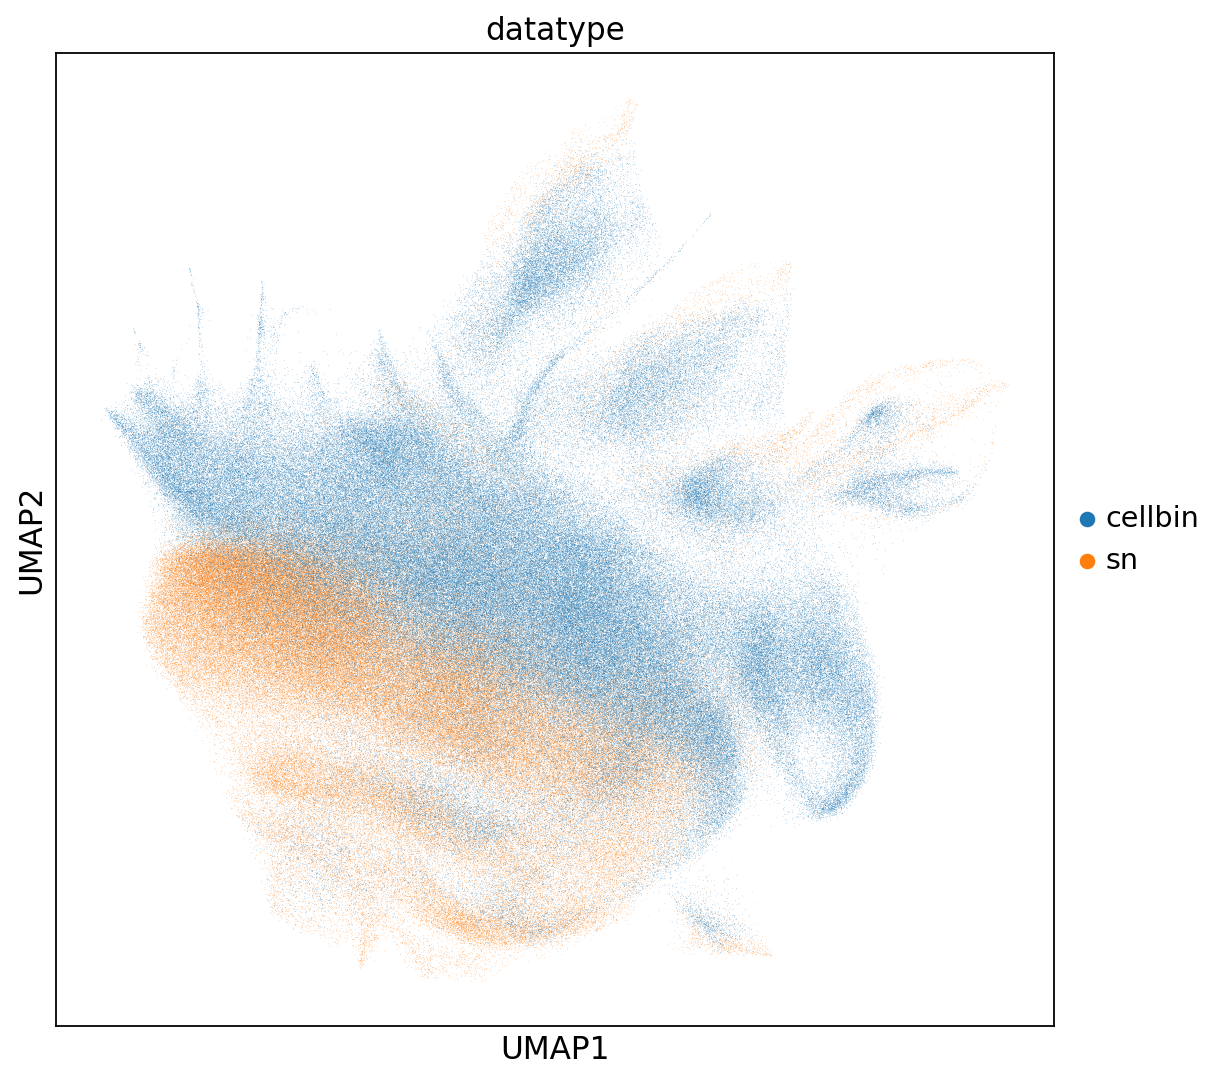

In [36]:
sc.pl.umap(combined_adata, color = "datatype")

# Single Sample

In [ ]:
single = cm.